In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import cv2

In [4]:
import scipy
import numpy as np
import cv2
import scipy.io

In [4]:
def undistort(I,fx,fy,cx,cy,K4,ox=None,oy=None,R = None):
    [nr,nc] = I.shape[:2]
    Irec = np.ones_like(I);
    ifx = 1/fx
    ify = 1/fy
    if R is None:
        R = np.eye(3)
    
    [mx,my] = np.meshgrid(np.arange(0,nc), np.arange(0,nr))
    px = mx.reshape(-1,1)
    py = my.reshape(-1,1)
    rays = np.hstack(((px ),(py ),np.ones(px.shape)));

    _px = ifx*((px)-cx)
    _py = ify*((py)-cy)
    _pz = np.ones_like(_py)
    
    rays =  np.hstack((_px,_py,_pz))
    rays2 = np.dot(R,rays.T)
    x = np.vstack((rays2[0,:]/rays2[2,:],rays2[1,:]/rays2[2,:]))
    #x = np.hstack((_px,_py)).T
    
    offset = [0,0]
    if ox is not None and oy is not None:
        ind = np.where((py==oy) & (px==ox))
        print(ind[0])
        offset = x[:,ind[0]]
    
    r2 = (x[0,:]-offset[0])**2+(x[1,:]-offset[1])**2
    cdist = 1+K4*(r2**2)
    xd1 = x * (np.ones((2,1))*cdist)
    print('K4',K4,offset)
   
    
    px2 = xd1[0,:]*fx+cx#p2[0,:]
    py2 = xd1[1,:]*fy+cy#p2[1,:]
    
    px_0 = np.floor(px2)
    py_0 = np.floor(py2)
    
    good_points = np.where((px_0 >= 0) & (px_0 < (nc-1)) & (py_0 >= 0) & (py_0 < (nr-1)))
    
    px2 = px2[good_points]
    py2 = py2[good_points]
    px_0 = px_0[good_points]
    py_0 = py_0[good_points]
    
    alpha_x = px2 - px_0;
    alpha_y = py2 - py_0;
    a1 = (1 - alpha_y)*(1 - alpha_x);
    a2 = (1 - alpha_y)*alpha_x;
    a3 = alpha_y * (1 - alpha_x);
    a4 = alpha_y * alpha_x;
    
    ind_lu = py_0 * nc + px_0 ;
    ind_ru = (py_0 + 1) * nc + px_0;
    ind_ld = py_0 * nc + (px_0 +1) ;
    ind_rd = (py_0 + 1) * nc + (px_0 +1) ;
    ind_new = (py[good_points])*nc + px[good_points];

    ind_lu = np.unravel_index(ind_lu.astype('int'),I.shape[:2])
    ind_ru = np.unravel_index(ind_ru.astype('int'),I.shape[:2])
    ind_ld = np.unravel_index(ind_ld.astype('int'),I.shape[:2])
    ind_rd = np.unravel_index(ind_rd.astype('int'),I.shape[:2])
    ind_new = np.unravel_index(np.squeeze(ind_new),I.shape[:2])
   
    Irec[ind_new] = a1 * I[ind_lu] + a3* I[ind_ru] + a2 * I[ind_ld] + a4 * I[ind_rd]
    #Irec[Irec>1] = 1
    #Irec[Irec<0] = 0
    print(np.mean(np.abs(Irec-I))*255,np.mean(Irec),np.mean(I),np.min(Irec)*255)
    return Irec

In [7]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
rgb = plt.imread('/Users/rsingh/Packages/toolbox_nyu_depth_v2/oyla_8.png')

In [39]:
depth = plt.imread('/Users/rsingh/Oyla/Data/10_Mar_data_March_10_11_02_09/raw/phase/oyla_8.png')
ampl = plt.imread('/Users/rsingh/Oyla/Data/10_Mar_data_March_10_11_02_09/raw/ampl//oyla_8.png')

In [29]:
rgb.shape

(360, 640, 4)

In [30]:
depth.shape

(120, 160, 4)

In [44]:
depth = cv2.resize(depth,(320,240), interpolation = cv2.INTER_CUBIC)
ampl = cv2.resize(ampl,(320,240), interpolation = cv2.INTER_CUBIC)

dir_path = '/Users/rsingh/Oyla/Data/12_Feb_data_February_12_20_16_19//'
for index in range(1000):

    data = scipy.io.loadmat(dir_path+'/data_1_'+str(index)+'.mat')['data']
    data2 = scipy.io.loadmat(dir_path+'/data_1_'+str(index+1)+'.mat')['data']
    rgb = data[0][4]
    raw_phase = data[0][2][0][0][:,:,0].transpose()
    raw_ampl = data[0][2][0][0][:,:,1].transpose()
    plt.imsave(dir_path+'raw/rgb/oyla_'+str(index)+'.png',np.fliplr(rgb))
    plt.imsave(dir_path+'raw/phase/oyla_'+str(index)+'.png',np.flipud(raw_phase))
    plt.imsave(dir_path+'raw/ampl/oyla_'+str(index)+'.png',np.flipud(raw_ampl))

In [10]:
raw_phase.shape

(160, 120)

In [45]:
_rgb = cv2.resize(rgb,None,fx=1/1.84,fy=1/1.84, interpolation = cv2.INTER_CUBIC)
_depth = cv2.resize(depth,None,fx=1.84,fy=1.84, interpolation = cv2.INTER_NEAREST)
_ampl = cv2.resize(ampl,None,fx=1.84,fy=1.84, interpolation = cv2.INTER_CUBIC)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


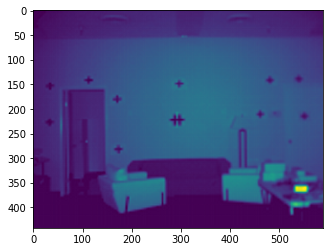

In [46]:
plt.imshow(_ampl)

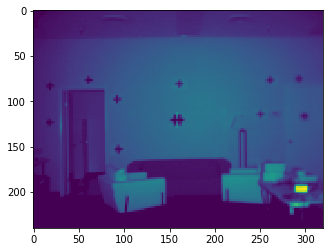

In [22]:
plt.imshow(ampl)

In [11]:
h, w = rgb.shape[:2]
print(h,w)
fx=2400/3
fy = 2400/3
cx = w//2
cy = h//2
ox = 93+cx
oy = 25+cy
KK_new=np.asarray([[fx,0,cx],[0,fy,cy],[0,0,1]])
K=-3.72e-1*2

360 640


In [47]:
h, w = _rgb.shape[:2]
print(w//2,h//2)
fx = 2400/5.52
fy = 2400/5.52
cx = w//2
cy = h//2
ox = 51+cx
oy = 14+cy
KK_new=np.asarray([[fx,0,cx],[0,fy,cy],[0,0,1]])
K=-4.21e-1

174 98


In [10]:
_rgb.shape

(196, 348, 4)

In [48]:
d = np.array([0,K,  0, 0,0])
print(d,KK_new)

[ 0.    -0.421  0.     0.     0.   ] [[434.7826087   0.        174.       ]
 [  0.        434.7826087  98.       ]
 [  0.          0.          1.       ]]


In [49]:
#rgb = np.fliplr(rgb)
newimg2 = np.ones_like(_rgb)
for i in range(0,3):
    print(i)
    newimg2[:,:,i] = undistort(_rgb[:,:,i],fx,fy,cx,cy,K4=K,oy=oy,ox=ox)

0
[39201]
K4 -0.421 [[0.1173]
 [0.0322]]
3.558676242828369 0.51617926 0.51053715 8.599883783608675
1
[39201]
K4 -0.421 [[0.1173]
 [0.0322]]
3.717135339975357 0.52398986 0.5181005 5.680175554007292
2
[39201]
K4 -0.421 [[0.1173]
 [0.0322]]
3.1321866530925035 0.5379847 0.5337707 31.7677678540349


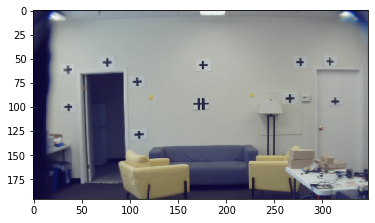

In [50]:
plt.imshow((newimg2))

In [51]:
plt.imsave('/Users/rsingh/Downloads/rgbUD.png',newimg2)

In [53]:
#ampl = cv2.resize(raw_ampl,None,fx=2,fy=2)
ampl[ampl<0]=0
ampl[ampl>1]=1
plt.imsave('/Users/rsingh/Downloads/depthUD.png',ampl)

newcameramatrix, roi = cv2.getOptimalNewCameraMatrix(KK_new, d, (w,h), 0)

mapx, mapy = cv2.initUndistortRectifyMap(KK_new, d, None, newcameramatrix, (w, h), 5)


newimg = cv2.remap(rgb, mapx, mapy, cv2.INTER_LINEAR)


plt.imshow(newimg)

plt.imsave('/Users/rsingh/Downloads/rgb.png',rgb)
plt.imsave('/Users/rsingh/Downloads/rgbUD.png',newimg)

np.mean(np.abs(newimg-rgb))

In [75]:
np.min(newimg2)

0.02745098

In [76]:
print(np.mean(np.abs(newimg2-rgb))*255)
print(np.mean(np.abs(newimg-rgb))*255)
print(np.mean(np.abs(newimg2-newimg))*255)

2.3847522726282477
2.0794837782159448
3.5958159249275923


In [173]:
angle = 70*np.pi/180

newImgVert = np.floor(np.sin(angle) * rgb.shape[1] + np.cos(angle) * rgb.shape[0]).astype('int')
newImgHorz = np.floor(np.sin(angle) * rgb.shape[0] + np.cos(angle) * rgb.shape[1]).astype('int')
out = np.zeros((newImgVert,newImgHorz,3))
vertical_center = out.shape[0]//2
horizontal_center = out.shape[1]//2
for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        vertical_position = np.cos(angle) *(i - vertical_center) + np.sin(angle) * (j - horizontal_center) + rgb.shape[0]//2;
        horizontal_position =  -np.sin(angle) *(i - vertical_center) + np.cos(angle) * (j - horizontal_center) + rgb.shape[1]//2;
        top = np.floor(vertical_position).astype('int')
        bottom = top + 1;
        left = np.floor(horizontal_position).astype('int')
        right = left + 1;
        if (top >= 0 and bottom < rgb.shape[0] and left >= 0 and right < rgb.shape[1] ):
            #         top = max((top,0))
            #         left = max((left,0))
            #         bottom = min((bottom,rgb.shape[0]-1))
            #         right = min((right,rgb.shape[1]-1))
            for k in range(3):
                interpolated = rgb[top,left,k]+rgb[bottom,right,k]
                out[i][j][k] = interpolated/2
        #else:
        #    print(top,left)
                

In [597]:
f = 1920/2*(1/np.tan(47/180*np.pi/2))

In [36]:
rgb = cv2.resize(rgb,None,fx=1/1.84,fy=1/1.84, interpolation = cv2.INTER_NEAREST)

In [39]:
np.asarray(rgb.shape)/2

array([ 98., 174.,   2.])

In [40]:
np.asarray(depth.shape)/2

array([120., 160.,   2.])

In [32]:
depth.shape

(442, 589, 4)

In [240]:
[nr,nc] = rgb.shape[:2]

In [598]:
f

2207.8488453468067

In [599]:
f = 1080/2*(1/np.tan(27.1/180*np.pi/2))

In [600]:
f

2240.6460884146877

In [265]:
np.meshgrid(np.arange(1,2), np.arange(1,3))[0]

array([[1],
       [1]])

In [257]:
np.arange(0,3)

array([0, 1, 2])

In [18]:
np.linalg.inv(KK_new)

array([[ 0.0023,  0.    , -0.4002],
       [ 0.    ,  0.0023, -0.2254],
       [ 0.    ,  0.    ,  1.    ]])

In [204]:
help(cv2.undistort)

Help on built-in function undistort:

undistort(...)
    undistort(src, cameraMatrix, distCoeffs[, dst[, newCameraMatrix]]) -> dst
    .   @brief Transforms an image to compensate for lens distortion.
    .   
    .   The function transforms an image to compensate radial and tangential lens distortion.
    .   
    .   The function is simply a combination of #initUndistortRectifyMap (with unity R ) and #remap
    .   (with bilinear interpolation). See the former function for details of the transformation being
    .   performed.
    .   
    .   Those pixels in the destination image, for which there is no correspondent pixels in the source
    .   image, are filled with zeros (black color).
    .   
    .   A particular subset of the source image that will be visible in the corrected image can be regulated
    .   by newCameraMatrix. You can use #getOptimalNewCameraMatrix to compute the appropriate
    .   newCameraMatrix depending on your requirements.
    .   
    .   The camera matr

In [88]:
cdist = np.asarray([2,3])

In [91]:
cdist[:,np.newaxis]

array([[2],
       [3]])

In [60]:
a= np.asarray(rgb.shape[:2])

In [61]:
b = np.asarray(depth.shape[:2])

In [76]:
np.max(np.vstack((a,b)),axis=0)

array([360, 640])

In [77]:
(1,-1)*a

array([ 360, -640])

In [67]:
b

array([240, 320])

In [73]:
np.vstack((a,b))

array([[360, 640],
       [240, 320]])

In [79]:
min((-1,-2))

-2

In [14]:
list(range(2,2+4))

[2, 3, 4, 5]